In [1]:
from google.colab import drive
import sys

%load_ext autoreload
%autoreload 2

drive.mount('/content/drive', force_remount=True)
sys.path.insert(0, '/content/drive/MyDrive/ML_project2')

Mounted at /content/drive


In [2]:
!ls

drive  sample_data


In [3]:
%cd 'drive/MyDrive/ML_project2/src'

/content/drive/MyDrive/ML_project2/src


# Training pipeline

In [24]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from models import Unet
from constants import *
from extract_dataset import extract_dataset, RoadDataset
from training import run_training
from testing import testing
from compute_metrics import compute_metrics

### 1) Extract data and labels

Here, we crop each image into 5 images of size 256 x 256 and we can choose to augment our data (we have initially 100 training images) :

In [5]:
training_data, training_labels = extract_dataset(augment=True)

Loading 100 images and crop them.
Augment data.


In [6]:
print('We now have:', len(training_data), 'images and labels to train our model.')

We now have: 3780 images and labels to train our model.


### 2) Split into training and validation set

In [7]:
# Split in training and validation set
train_data, validation_data, train_labels, validation_labels = train_test_split(training_data, training_labels, test_size=0.2, random_state=42)

### 3) Build datasets and Dataloader

In [8]:
# Build training and validation datasets
train_set = RoadDataset(train_data, train_labels)
validation_set = RoadDataset(validation_data, validation_labels)

# Build dataloader
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(validation_set, batch_size=BATCH_SIZE, shuffle=False)

### 4) Start training with a Unet neural network

In [25]:
# Set parameters to train 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Unet(channels=32,batch_normalization=True,drop=True,prob=0.3,dilation_mode=1)
optimizer_kwargs = dict(lr=1e-3, weight_decay=1e-3,)
model = model.to(device=device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), **optimizer_kwargs)

In [26]:
# Train
model.train()
train_losses = []
val_losses = []
train_f1s = []
val_f1s = []

loss_train_history = []
f1_train_history = []
best_f1 = 0

for epoch in range(1, NUM_EPOCHS + 1):
    print('\n-------------> epoch: {}'.format(epoch))
    #train_loss, train_acc, lrs = train_epoch(model, optimizer, criterion, train_loader, epoch, device)
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = data.permute(0, 3, 1, 2)
        optimizer.zero_grad()
        
        output = model(data)
        loss = criterion(output, target)

        pred = torch.round(output)
        # Compute confusion vector between 2 tensors
        confusion_vector = pred / target
        # Compute validation f1 score
        f1_train = compute_metrics(confusion_vector, print_values=False)
        f1_train_history.append(f1_train)
        
        loss.backward()
        optimizer.step()         
        loss_float = loss.item()
        loss_train_history.append(loss_float)

    train_loss = np.mean(loss_train_history)
    train_losses.append(train_loss)
    epoch_f1 = np.mean(f1_train_history)
    train_f1s.append(epoch_f1)
    print('Loss score for training:', train_loss)
    print('F1 score for training:', epoch_f1)

    #  Validate Model 
    model.eval()
    loss_val_history = []
    f1_val_history = []
    for data_val, target_val in val_loader:
        data_val, target_val = data_val.to(device), target_val.to(device)
        data_val = data_val.permute(0, 3, 1, 2)

        output_val = model(data_val)

        loss_val = criterion(output_val, target_val).item()
        loss_val_history.append(loss_val)

        pred_val = torch.round(output_val)

        # Compute confusion vector between 2 tensors
        confusion_vector_val = pred_val / target_val
        # Compute validation f1 score
        f1_val = compute_metrics(confusion_vector_val, print_values=False)
        f1_val_history.append(f1_val)
    
    val_loss = np.mean(loss_val_history)
    val_losses.append(val_loss)
    epoch_f1_val = np.mean(f1_val_history)
    val_f1s.append(epoch_f1_val)
    print('\nLoss score for validation:', val_loss)
    print('F1 score for validation:', epoch_f1_val)

    # Save model if best
    if epoch_f1_val > best_f1:
        best_f1 = epoch_f1_val
        best_model = model
        torch.save(model.state_dict(), 'models/best_model_100epoch.pth')
        print('-------------> NEW BEST MODEL SAVED')



-------------> epoch: 1
Loss score for training: 0.4868089738030913
F1 score for training: 0.5155249660822658

Loss score for validation: 0.37972284480929375
F1 score for validation: 0.5932887970684685
-------------> NEW BEST MODEL SAVED

-------------> epoch: 2
Loss score for training: 0.4072608033973704
F1 score for training: 0.5801064611825822

Loss score for validation: 0.28464220960934955
F1 score for validation: 0.7322508848798561
-------------> NEW BEST MODEL SAVED

-------------> epoch: 3
Loss score for training: 0.3514704242269829
F1 score for training: 0.6387457092909928

Loss score for validation: 0.21948460737864176
F1 score for validation: 0.7872124729313557
-------------> NEW BEST MODEL SAVED

-------------> epoch: 4
Loss score for training: 0.3133541049149932
F1 score for training: 0.679753996090703

Loss score for validation: 0.18727965683986744
F1 score for validation: 0.82438135460464
-------------> NEW BEST MODEL SAVED

-------------> epoch: 5
Loss score for trainin

KeyboardInterrupt: ignored

Here are the training and validation losses and f1 score:

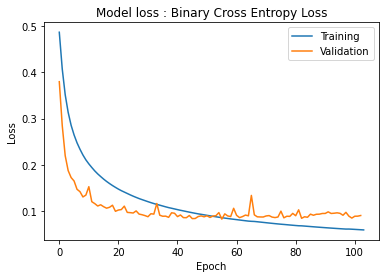

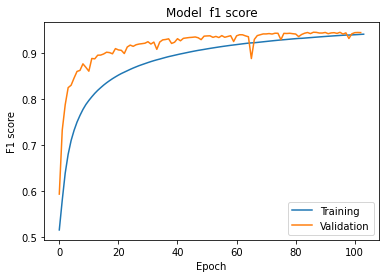

In [27]:
# model loss

plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Model loss : Binary Cross Entropy Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()
plt.close()

print('\n')
# model accuracy metric

plt.plot(train_f1s)
plt.plot(val_f1s)
plt.title('Model  f1 score')
plt.ylabel('F1 score')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()
plt.close()

Based on the f1 score we save the best model and we can then apply it to our testing images

## Testing pipeline

Here we set the TRAINING parameter to False, and only the TESTING parameter to True. If you want to run it all, just set both parameter to True.

In [28]:
import run

Start testing
Submission saved
